[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/annanasnas/semantic_segmentation-25/blob/main/DomainShift.ipynb)

In [1]:
import random
import numpy as np
import torch

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

In [2]:
REPO = "https://github.com/annanasnas/semantic_segmentation-25.git"
!git clone $REPO
%cd /content/semantic_segmentation-25
!pip install -q -r requirements.txt pyyaml

Cloning into 'semantic_segmentation-25'...
remote: Enumerating objects: 255, done.
remote: Counting objects: 100% (255/255), done.
remote: Compressing objects: 100% (176/176), done.
remote: Total 255 (delta 134), reused 180 (delta 65), pack-reused 0 (from 0)
Receiving objects: 100% (255/255), 3.97 MiB | 5.92 MiB/s, done.
Resolving deltas: 100% (134/134), done.
/content/semantic_segmentation-25
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


## Config

In [3]:
import yaml

with open("configs/domain shift.yaml", "r", encoding="utf-8") as f:
    cfg = yaml.safe_load(f)

# !python scripts/download_data.py

batch_size = cfg["train"]["batch_size"]
epochs = cfg["train"]["epochs"]
learning_rate = cfg["train"]["lr"]

dir_train = cfg["data"]["dir_train"]
dir_val = cfg["data"]["dir_val"]
img_size_train = tuple(cfg["data"]["img_size_train"])
img_size_val = tuple(cfg["data"]["img_size_val"])

name = cfg["model"]["name"]

## DataLoaders

In [4]:
from datasets.cityscapes import CityScapes
from datasets.gta5 import GTA5Dataset
from torch.utils.data import DataLoader
from torchvision import transforms


imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

train_dataset = GTA5Dataset(
    root_dir=dir_train,
    image_transform=image_transforms,
    image_size=img_size_train
)

val_dataset = CityScapes(
    root_dir=dir_val,
    split="val",
    image_transform=image_transforms,
    image_size=img_size_val
)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

## Training

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
import torch.optim as optim
import torch.nn as nn
from models.bisenet.build_bisenet import BiSeNet
from torch.amp import GradScaler
from scripts.checkpoint import Checkpoint
from pathlib import Path
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BiSeNet(num_classes=19, context_path='resnet18')
optimizer = optim.SGD(model.optim_parameters(lr=learning_rate), momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(ignore_index=255)
scaler = GradScaler()
max_iter = len(train_dataloader) * epochs

model.to(device);

In [6]:
# load checkpoint if exists
ckpt_dir = Path("/content/drive/MyDrive/semantic segmentation/checkpoints") / name
log_csv  = ckpt_dir / "log.csv"
ckpt_mgr = Checkpoint(ckpt_dir)

last_path = ckpt_dir / "last.pth"
if last_path.exists():
    ckpt = torch.load(last_path, map_location="cpu", weights_only=False)
    model.load_state_dict(ckpt["model"])
    optimizer.load_state_dict(ckpt["optimizer"])
    scaler.load_state_dict(ckpt["scaler"])
    start_epoch = ckpt["epoch"]
    iteration = ckpt["iteration"]
    best_miou   = ckpt["best_miou"]
    df_prev = pd.read_csv(log_csv)
    metrics = df_prev.to_dict("list")
else:
    start_epoch = 0
    best_miou   = 0
    iteration = 0
    metrics = {"epoch": [], "train_loss": [], "val_loss": [], "val_miou": []}


In [9]:
from scripts.train import train_bisenet

train_bisenet(start_epoch, epochs, model,
              train_dataloader, val_dataloader, device,
              optimizer, criterion, scaler,
              learning_rate, max_iter, iteration,
              best_miou, metrics, ckpt_mgr, log_csv)

# Results

In [ ]:
from scripts.train import validate

model = BiSeNet(num_classes=19, context_path='resnet18')

best_path = ckpt_dir / "best.pth"
best_model = torch.load(best_path, map_location=device)
model.load_state_dict(best_model["model"])
validate(model, val_dataloader, device) * 100

Per-class IoU
Road            : 33.0568
Sidewalk        : 10.0924
Building        : 40.9673
Wall            : 6.5245
Fence           : 8.9788
Pole            : 8.4249
Traffic light   : 0.1643
Traffic sign    : 0.0000
Vegetation      : 68.9083
Terrain         : 10.7935
Sky             : 53.9147
Person          : 31.4355
Rider           : 0.0000
Car             : 46.0996
Truck           : 18.1325
Bus             : 10.5846
Train           : 0.0000
Motorcycle      : 0.0000
Bicycle         : 0.0000
Mean IoU: 18.3199


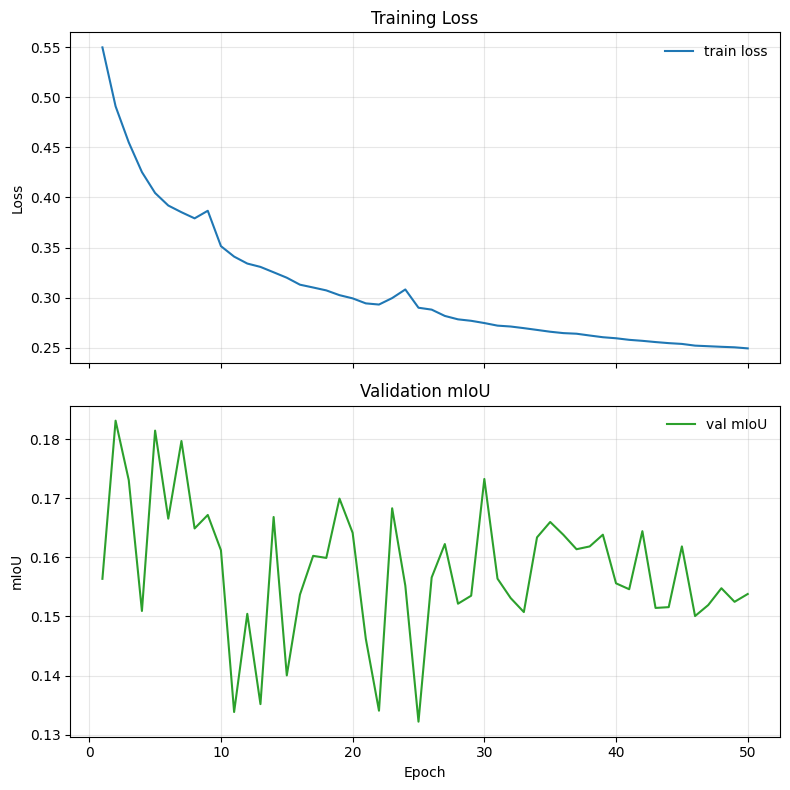

In [ ]:
from scripts.utils import plot_log

plot_log(log_csv)

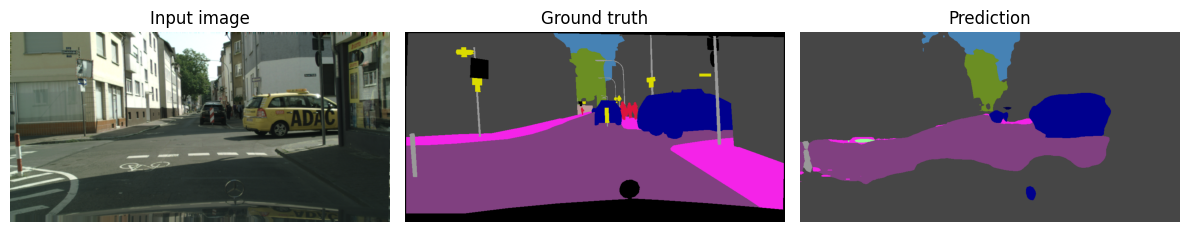

In [ ]:
from scripts.utils import visualize_sample

model.to("cpu")
visualize_sample(val_dataloader, model)